In [1]:
import numpy as np 
import pandas as pd
import os, dicom, fnmatch, random, time, cv2

from sklearn import svm
from sklearn.metrics import precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
from scipy.stats import entropy 

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def chisquaredist(array1, array2):
    if len(array1) != len(array2):
        raise ValueError('Input arrays need to be the same size.')
    return sum([ ( (array1[i] - array2[i]) ** 2 ) / (array1[i] + array2[i]) for i in range(len(array1))])

def getFile(directory, ftype):
    matches = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, '*.'+ftype):
            matches.append(os.path.join(root, filename))
    return matches

def evalClustering(data, min_clust=2, max_clust=31):
    sil_score = []
    for n in range(min_clust, max_clust):
        kmeans = KMeans(n_clusters = n, random_state = 10)
        clt_lab = kmeans.fit_predict(data)
        sil_avg = silhouette_score(data, clt_lab)
        print('for {} clusters, sil score is {}'.format(n, sil_avg))
        sil_score.append(sil_avg)
    
    plt.plot(range(min_clust, max_clust), sil_score)
    plt.title('Average Silhouette Score Scree Plot', fontsize=14)
    ax = plt.axes()
    ax.set_xticks(range(min_clust, max_clust, round((max_clust-min_clust)/10)))
    ax.set_xlabel('Number of clusters (K)')
    ax.set_ylabel('Average Silhouette Score')
    return sil_score

def transformImg(features, centers):
    '''
    * features is a dictionary
    * centers is np array
    '''
    img_hist = {}
    for i in features:
        hist = np.zeros(len(centers))
        feat = features[i]['features']
        for f in feat:
            temp_sim = []
            for center in centers:
                temp_sim.append(euclidean(f, center))
            hist[temp_sim.index(max(temp_sim))] += 1
        img_hist[i] = hist
    return img_hist

def retrieve(train, test, labels):
    '''
    input two histogram represented dataset
    output L1, chi, kL results
    '''
    L1_results = {}
    chi_results = {}
    KL_results = {}
    for i in [1, 0]:
        L1_results[i] = []
        chi_results[i] = []
        KL_results[i] = []
    db_labels = [int(labels[labels.Image == i].Label) for i in train]
    for i in test:
        L1_r = []
        chi_r = []
        KL_r = []
        for j in train:
            query_hist = test[i]
            db_hist = train[j]
            L1_r.append(cityblock(query_hist, db_hist))
            chi_r.append(chisquaredist(query_hist, db_hist))
            KL_r.append(entropy(query_hist, db_hist))
        L1_output = [x for (y, x) in sorted(zip(L1_r, db_labels))]
        chi_output = [x for (y, x) in sorted(zip(chi_r, db_labels))]
        KL_output = [x for (y, x) in sorted(zip([1 if x == float('inf') else x for x in KL_r], db_labels))]
        
        curr_label = int(labels[labels.Image == i].Label)
        L1_results[curr_label].append(L1_output)
        chi_results[curr_label].append(chi_output)
        KL_results[curr_label].append(KL_output)
        
    return L1_results, chi_results, KL_results

def evaluate(d):
    MAP = {}
    MAR = {}
    for i in d:
        MAP[i], MAR[i] = [], []
    for i in d:
        map_temp = []
        mar_temp = []
        for j in d[i]:
            tp, fp, temp_pre, temp_rec = 0, 0, [], []
            for out in j:
                if out == i:
                    tp += 1
                else:
                    fp += 1
                temp_pre.append(tp/(tp+fp))
                temp_rec.append(tp/len(j))
            map_temp.append(mean(temp_pre))
            mar_temp.append(mean(temp_rec))
        MAP[i] = mean(map_temp)
        MAR[i] = mean(mar_temp)
    return MAP, MAR

def displayResults(P, R):
    to_display, p, r = [], [], []
    for (k, v), (k2, v2) in zip(P.items(), R.items()):
        to_display.append([k, v, v2])
        p.append(v)
        r.append(v2)
    to_display.append(['Average', mean(p), mean(r)])
    return pd.DataFrame(to_display, columns=['Type', 'Precision', 'Recall'])

def mean(arr):
    return sum(arr)/len(arr)

In [3]:
labels = pd.read_excel('LIDC_Label.xlsx')
with_nod = labels[labels.Label == 1]
without_nod = labels[labels.Label == 0]

In [4]:
print(with_nod.shape[0])
print(without_nod.shape[0])

883
9469


#### Split training (70%) and query/testing (30%)

In [5]:
train = round(with_nod.shape[0]*0.7)
print(train)
print(with_nod.shape[0]-train)

618
265


In [6]:
nod = with_nod.Image.values
no_nod = without_nod.Image.values

In [7]:
nod_train = random.sample(list(nod), 618)
nod_query = random.sample(list(set(nod) - set(nod_train)), 265)

In [8]:
print(len(set(nod_train))+ len(set(nod_query)))

883


### Save params

In [9]:
np.save("var/nod_train.npy", nod_train)
np.save('var/nod_query.npy', nod_query)

In [10]:
nod_train = np.load("var/nod_train.npy")
nod_query = np.load('var/nod_query.npy')

In [11]:
no_nod_subset = []
by_patient = {}
for dcm in no_nod:
    if dcm[20:24] not in by_patient:
        by_patient[dcm[20:24]] = []
        by_patient[dcm[20:24]].append(dcm)
    else:
        by_patient[dcm[20:24]].append(dcm)
for i in by_patient:
    no_nod_subset+= random.sample(by_patient[i], 15)
print(len(no_nod_subset))

900


In [12]:
no_nod_subset[0]

'LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192/000006.dcm'

In [13]:
no_nod_subset_train = random.sample(no_nod_subset, 618)
no_nod_subset_query = random.sample(list(set(no_nod_subset) - set(no_nod_subset_train)), 900-618)

### Save params

In [14]:
np.save('var/no_nod_subset.npy', no_nod_subset)
np.save("var/no_nod_subset_train.npy", no_nod_subset_train)
np.save('var/no_nod_subset_query.npy', no_nod_subset_query)

In [15]:
no_nod_subset = np.load('var/no_nod_subset.npy')
no_nod_subset_train = np.load('var/no_nod_subset_train.npy')
no_nod_subset_query = np.load('var/no_nod_subset_query.npy')

In [16]:
print(len(set(no_nod_subset_train))+len(set(no_nod_subset_query)))

900


In [17]:
print("Nodule training: {}".format(len(nod_train)))
print("Nodule query: {}".format(len(nod_query)))
print("No nodule training: {}".format(len(no_nod_subset_train)))
print("No nodule query: {}".format(len(no_nod_subset_query)))

Nodule training: 618
Nodule query: 265
No nodule training: 618
No nodule query: 282


In [18]:
nod_train = [x.replace('.dcm', '.jpg') for x in nod_train]

In [19]:
train = [x.replace('.jpg', '.dcm') for x in nod_train] + list(no_nod_subset_train)
query = list(nod_query) + list(no_nod_subset_query)

### Save params

In [20]:
np.save('var/train.npy', train)
np.save('var/query.npy', query)

In [21]:
train = np.load('var/train.npy')
query = np.load('var/query.npy')

#### Generate SIFT

##### With nodules

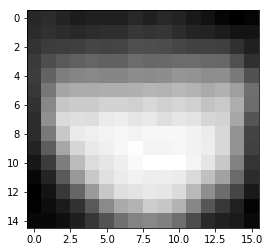

In [22]:
plt.imshow(cv2.cvtColor(cv2.imread(nod_train[0]), cv2.COLOR_BGR2GRAY), cmap='gray')

In [23]:
start = time.time()
SIFT = {}
for nod in nod_train:
    image = cv2.cvtColor(cv2.imread(nod), cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(image, None)
    SIFT[nod] = {}
    SIFT[nod]['keypoints'] = kp
    SIFT[nod]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 0.6353788375854492 seconds


##### Without nodules

In [24]:
start = time.time()
for dcm in no_nod_subset_train:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    SIFT[dcm] = {}
    SIFT[dcm]['keypoints'] = kp
    SIFT[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 82.42260885238647 seconds


##### Aggregate

In [25]:
SIFT_feat = np.empty((1, 128))
no_SIFT_feat = 0
no_SIFT_slices = []
for i in SIFT:
    try:
        SIFT_feat = np.concatenate([SIFT_feat, SIFT[i]['features']])
    except:
        no_SIFT_slices.append(i)
        no_SIFT_feat+=1
        continue
SIFT_feat = np.delete(SIFT_feat, 0, 0)

In [26]:
print('{} nodules do not have SIFT features.'.format(no_SIFT_feat))

223 nodules do not have SIFT features.


In [27]:
SIFT_feat.shape

(248641, 128)

In [28]:
np.savetxt('to_clust.csv', SIFT_feat, delimiter = ',')

### All training and query images (whole CT scans for those having nodules)

In [29]:
train_images = {}
start = time.time()
for dcm in train:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    train_images[dcm] = {}
    train_images[dcm]['keypoints'] = kp
    train_images[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 167.334734916687 seconds


In [30]:
len(train_images.keys())

1236

In [31]:
query_images = {}
start = time.time()
for dcm in query:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 400)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    query_images[dcm] = {}
    query_images[dcm]['keypoints'] = kp
    query_images[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 74.74520993232727 seconds


In [32]:
len(query_images.keys())

547

### Cluster Center From Spark

In [33]:
centers = np.load('var/cluster_centers.npy')

### Transform Images

In [34]:
start = time.time()
database = transformImg(train_images, centers)
end = time.time()
print('Time taken {}'.format(end-start))

Time taken 814.671407699585


In [35]:
len(database.keys())

1236

In [36]:
start = time.time()
queryHist = transformImg(query_images, centers)
end = time.time()
print('Time taken {}'.format(end-start))

Time taken 355.2191731929779


In [37]:
len(queryHist.keys())

547

In [38]:
L1_labels, chi_labels, KL_labels = retrieve(database, queryHist, labels)

/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [39]:
L1_MAP, L1_MAR = evaluate(L1_labels)
chi_MAP, chi_MAR = evaluate(chi_labels)
KL_MAP, KL_MAR = evaluate(KL_labels)

In [40]:
displayResults(L1_MAP, L1_MAR)

,Type,Precision,Recall
0,1,0.572496,0.281010
1,0,0.510164,0.245664
2,Average,0.541330,0.263337


In [41]:
displayResults(chi_MAP, chi_MAR)

,Type,Precision,Recall
0,1,0.846371,0.375202
1,0,0.153629,0.125202
2,Average,0.500000,0.250202


In [42]:
displayResults(KL_MAP, KL_MAR)

,Type,Precision,Recall
0,1,0.263871,0.149033
1,0,0.747845,0.352101
2,Average,0.505858,0.250567


#### Try SVM

In [43]:
y = []
for i in database:
    y.append(int(labels[labels.Image == i].Label))

'kernel': ["linear", "rbf"]

## Linear Kernel

In [44]:
clf = svm.SVC(kernel = 'linear')
roc_cv = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="roc_auc")
prec = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="precision")
rec = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="recall")
print('10-CV ROC: {}'.format(roc_cv.mean()))
print('10-CV prec: {}'.format(prec.mean()))
print('10-CV rec: {}'.format(rec.mean()))

10-CV ROC: 0.6917010521323277
10-CV prec: 0.6219733098796356
10-CV rec: 0.7767318878900052


### Gaussian/RBF Kernle

In [45]:
roc_all = []
prec_all = []
rec_all = []
for g in np.linspace(0, 1, 100):
    if g == 0:
        continue
    else:
        clf = svm.SVC(kernel = 'rbf', gamma = g)
        roc_cv = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="roc_auc")
        prec = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="precision")
        rec = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="recall")
        roc_all.append(roc_cv.mean())
        prec_all.append(prec.mean())
        rec_all.append(rec.mean())

/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/s

/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/python3/lib/python3.6/site-packages/s

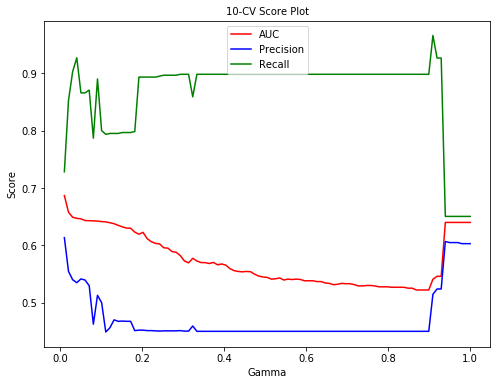

In [46]:
plt.figure().set_size_inches(8, 6)
plt.plot(np.linspace(0, 1, 100)[1:], roc_all, 'r', label="AUC")
plt.plot(np.linspace(0, 1, 100)[1:], prec_all, 'b', label="Precision") 
plt.plot(np.linspace(0, 1, 100)[1:], rec_all, 'g', label='Recall')
plt.ylabel('Score')
plt.xlabel('Gamma')
plt.title('10-CV Score Plot', fontsize=10)
plt.legend()

In [47]:
roc_all_2 = []
prec_all_2 = []
rec_all_2 = []
for g in np.linspace(0, 0.1, 100):
    if g == 0:
        continue
    else:
        clf = svm.SVC(kernel = 'rbf', gamma = g)
        roc_cv = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="roc_auc")
        prec = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="precision")
        rec = cross_val_score(clf, np.array(list(database.values())), y, cv=10, scoring="recall")
        roc_all_2.append(roc_cv.mean())
        prec_all_2.append(prec.mean())
        rec_all_2.append(rec.mean())

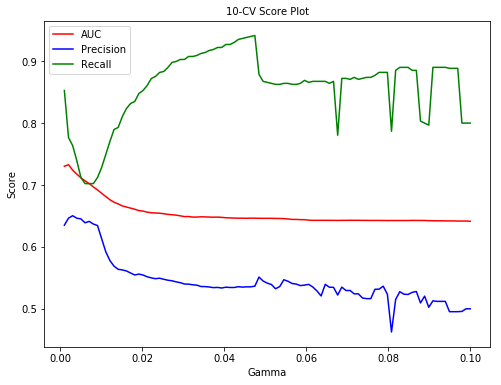

In [48]:
plt.figure().set_size_inches(8, 6)
plt.plot(np.linspace(0, 0.1, 100)[1:], roc_all_2, 'r', label="AUC")
plt.plot(np.linspace(0, 0.1, 100)[1:], prec_all_2, 'b', label="Precision") 
plt.plot(np.linspace(0, 0.1, 100)[1:], rec_all_2, 'g', label='Recall')
plt.ylabel('Score')
plt.xlabel('Gamma')
plt.title('10-CV Score Plot', fontsize=10)
plt.legend()

RBF's default gamma value is 1/n_samples. it looks like that's the right value to choose, so we go with that default setting

## Final SVM Result

In [49]:
for j in ['linear', 'rbf']:
    print(j)
    clf = svm.SVC(kernel = j)
    clf.fit(np.array(list(database.values())), y)
    pred_label = clf.predict(np.array(list(queryHist.values())))
    true_label = []
    for i in queryHist:
        true_label.append(int(labels[labels.Image == i].Label))
    print('Score by Class [0]   [1]')
    print(precision_score(true_label, pred_label, average=None))
    print(recall_score(true_label, pred_label, average=None))
    print()
    print('Average')
    print(precision_score(true_label, pred_label))
    print(recall_score(true_label, pred_label))
    print()
    print()

linear
Score by Class [0]   [1]
[ 0.69339623  0.59701493]
[ 0.5212766   0.75471698]

Average
0.597014925373
0.754716981132


rbf
Score by Class [0]   [1]
[ 0.75784753  0.65123457]
[ 0.59929078  0.79622642]

Average
0.651234567901
0.796226415094


